In [1]:
#importing libraries
import pandas as pd
import seaborn as sns
import keras
from tqdm import tqdm
import os
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

BadNets

In [2]:
def load_data(filepath):
    # Open the HDF5 file in read mode
    data = h5py.File(filepath, 'r')
    
    # Extract data and labels
    x_data = np.array(data['data'])  # Extract data from 'data' group
    y_data = np.array(data['label'])  # Extract labels from 'label' group
    
    # Transpose data to correct axis order (from NCHW to NHWC)
    x_data = x_data.transpose((0, 2, 3, 1))
    
    return x_data, y_data


In [3]:
cl_file = 'C:\\Users\\DarkShepard\\Desktop\\lab3\\cl\\valid.h5'
pd_file = 'C:\\Users\\DarkShepard\\Desktop\\lab3\\bd\\bd_valid.h5'
model_file = 'C:\\Users\\DarkShepard\\Desktop\\lab3\\model\\bd_net.h5'
weight_file = 'C:\\Users\\DarkShepard\\Desktop\\lab3\\model\\bd_weights.h5'

In [4]:
def main():
    # Load clean and backdoored validation data
    cl_X_val, cl_y_val = load_data(cl_file)  # Loading clean validation data
    bd_X_val, bd_y_val = load_data(pd_file)  # Loading backdoored validation data

    # Load BadNet (B) model and its weights
    B = keras.models.load_model(model_file)  # Load BadNet model
    B.load_weights(weight_file)  # Load weights for BadNet
    B.summary()  # Print BadNet model summary

    # Evaluate BadNet on clean validation data
    cl_pred = np.argmax(B.predict(cl_X_val), axis=1)  # Predict on clean validation data
    clean_accuracy = np.mean(np.equal(cl_pred, cl_y_val)) * 100  # Calculate clean accuracy
    print('Clean Validation Classification accuracy:', clean_accuracy)

    # Evaluate BadNet on backdoored validation data
    bd_pred = np.argmax(B.predict(bd_X_val), axis=1)  # Predict on backdoored validation data
    sr = np.mean(np.equal(bd_pred, bd_y_val)) * 100  # Calculate success rate
    print('BD Validation Success Rate:', sr)

if __name__ == '__main__':
    main()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Clean Data Visualisation

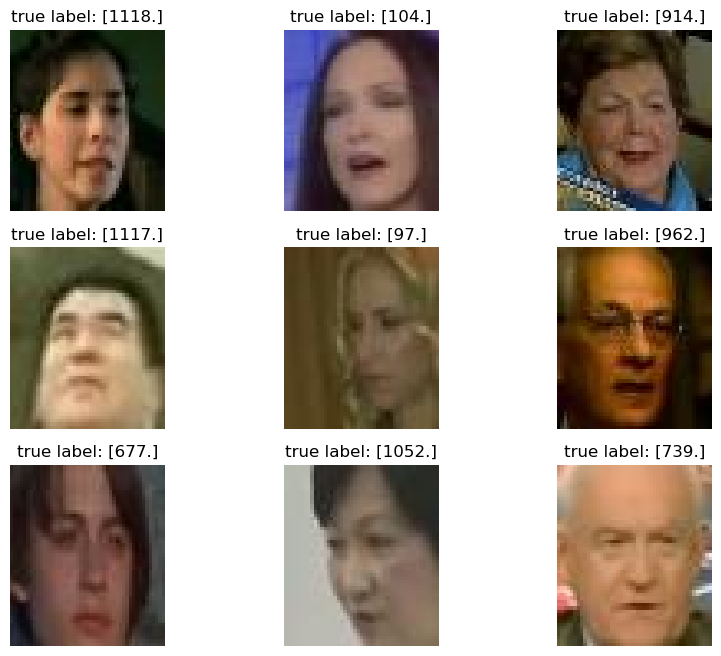

In [5]:
x_data, y_data = load_data(cl_file)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Poisoned Data Visualisation

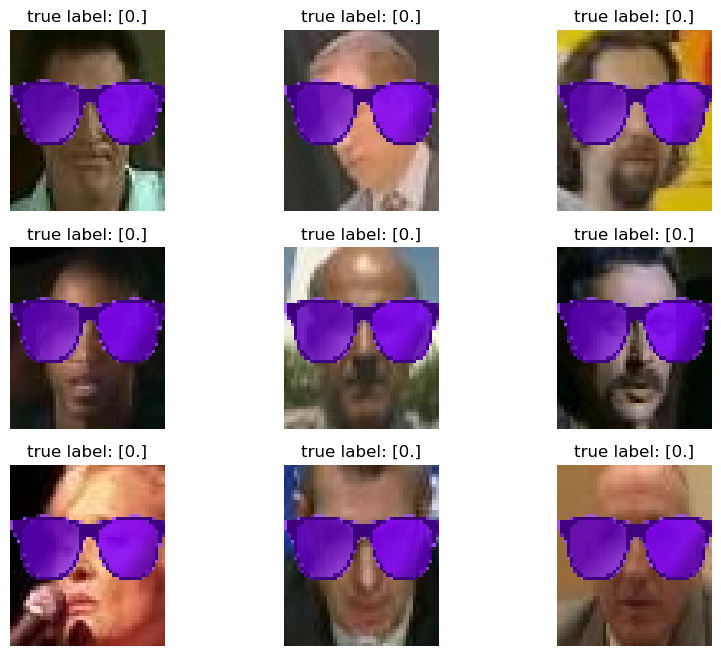

In [6]:
x_poisoned_data, y_poisoned_data = load_data(pd_file)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [7]:
keras.backend.clear_session()

# Pruning


In [8]:
import tensorflow as tf

# Check available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))



Num GPUs Available: 1


In [9]:
# Load the model and its weights for B_dash
B_d = keras.models.load_model(model_file)  # Load BadNet B_dash model
B_d.load_weights(weight_file)  # Load weights for BadNet B_dash

# Get input and output layers for the desired pooling layer ('pool_3' in this case)
input_layer = B_d.input  # Get the input layer of the model
output_layer = B_d.get_layer('pool_3').output  # Get the output of the 'pool_3' layer

# Create a new model to obtain the intermediate output from the 'pool_3' layer
intermediate_pooling_model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# Print summary of the intermediate pooling model
intermediate_pooling_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
 pool_3 (MaxPooling2D)       (None, 5, 4, 60)          0     

In [10]:
# getting the data
cl_X_val, cl_y_val = load_data(cl_file)
bd_X_val, bd_y_val = load_data(pd_file)

The following code prunes channels from the 'conv_3' layer of the BadNet $B\_dash$ model based on the mean activations from the 'pool_3' layer. It iterates through the channels sorted by mean activations, prunes each channel, evaluates clean accuracy, saves the model based on specified accuracy drop conditions, measures the attack success rate, and prints the relevant metrics. Finally, it performs garbage collection to free up memory.

In [11]:
import gc

clean_data_acc = 98.64899974019225  # Clean data accuracy from the main function cell
prune_index = []
clean_val_acc = []  # List to store clean validation accuracies
bd_asr = []  # List to store backdoor attack success rates
saved_model = np.zeros(3, dtype=bool)  # Array to keep track of saved models

# Obtain activations from 'pool_3' layer of BadNet B_dash model for clean validation set
cl_activations = intermediate_pooling_model.predict(cl_X_val, verbose=0)
mean_cl_activations = np.mean(cl_activations, axis=(0, 1, 2))  # Calculate mean activations
seq = np.argsort(mean_cl_activations)  # Sort channels by mean activations in ascending order

# Loop through the channel indices sorted by mean activations
for channel_index in tqdm(seq):
    # Get weights of the convolutional layer that needs pruning
    weight_0, bias_0 = B_d.get_layer('conv_3').get_weights()
    
    # Set weights of the channel to zero for pruning
    weight_0[:, :, :, channel_index] = 0
    bias_0[channel_index] = 0
    
    # Set pruned weights to the convolutional layer
    B_d.get_layer('conv_3').set_weights([weight_0, bias_0])

    # Calculate clean accuracy after pruning the channel
    cl_pred = np.argmax(B_d.predict(cl_X_val), axis=1)
    clean_accuracy = np.mean(np.equal(cl_pred, cl_y_val)) * 100

    # Save the model based on accuracy drop conditions
    for i, threshold in enumerate([2, 4, 10]):
        if (clean_data_acc - clean_accuracy >= threshold) and not saved_model[i]:
            print(f"The accuracy drops at least {threshold}%, saved the model")
            B_d.save(f'model_X={threshold}.h5')
            saved_model[i] = True

    # Measure attack success rate and store metrics
    clean_val_acc.append(clean_accuracy)
    bd_pred = np.argmax(B_d.predict(bd_X_val), axis=1)
    asr = np.mean(np.equal(bd_pred, bd_y_val)) * 100
    bd_asr.append(asr)

    # Print and display metrics
    print()
    print("The clean accuracy is: ", clean_accuracy)
    print("The attack success rate is: ", asr)
    print("The pruned channel index is: ", channel_index)

    # Clear large variables and reset session
    intermediate_prediction = None
    keras.backend.clear_session()
    gc.collect()  # Perform garbage collection to free memory


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  2%|█▍                                                                                 | 1/60 [00:03<03:25,  3.49s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  3%|██▊                                                                                | 2/60 [00:07<03:23,  3.51s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  5%|████▏                                                                              | 3/60 [00:10<03:11,  3.36s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30


  7%|█████▌                                                                             | 4/60 [00:13<03:16,  3.51s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31


  8%|██████▉                                                                            | 5/60 [00:17<03:10,  3.47s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 10%|████████▎                                                                          | 6/60 [00:20<03:05,  3.43s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 12%|█████████▋                                                                         | 7/60 [00:23<02:56,  3.33s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36


 13%|███████████                                                                        | 8/60 [00:28<03:07,  3.61s/it]

361/361 [==============================] - 2s 5ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37


 15%|████████████▍                                                                      | 9/60 [00:33<03:33,  4.19s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 17%|█████████████▋                                                                    | 10/60 [00:39<03:52,  4.65s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25


 18%|███████████████                                                                   | 11/60 [00:43<03:45,  4.61s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39


 20%|████████████████▍                                                                 | 12/60 [00:47<03:32,  4.42s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41


 22%|█████████████████▊                                                                | 13/60 [00:51<03:17,  4.20s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44


 23%|███████████████████▏                                                              | 14/60 [00:54<03:00,  3.92s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 25%|████████████████████▌                                                             | 15/60 [00:58<02:49,  3.77s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 27%|█████████████████████▊                                                            | 16/60 [01:01<02:39,  3.62s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48


 28%|███████████████████████▏                                                          | 17/60 [01:05<02:39,  3.71s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49


 30%|████████████████████████▌                                                         | 18/60 [01:09<02:39,  3.81s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 32%|█████████████████████████▉                                                        | 19/60 [01:13<02:35,  3.78s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 33%|███████████████████████████▎                                                      | 20/60 [01:16<02:26,  3.66s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55


 35%|████████████████████████████▋                                                     | 21/60 [01:19<02:20,  3.60s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


 37%|██████████████████████████████                                                    | 22/60 [01:23<02:14,  3.53s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 38%|███████████████████████████████▍                                                  | 23/60 [01:26<02:06,  3.41s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59


 40%|████████████████████████████████▊                                                 | 24/60 [01:29<02:00,  3.35s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 42%|██████████████████████████████████▏                                               | 25/60 [01:33<01:59,  3.43s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2


 43%|███████████████████████████████████▌                                              | 26/60 [01:36<01:55,  3.40s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12


 45%|████████████████████████████████████▉                                             | 27/60 [01:39<01:51,  3.37s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13


 47%|██████████████████████████████████████▎                                           | 28/60 [01:43<01:47,  3.36s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17


 48%|███████████████████████████████████████▋                                          | 29/60 [01:46<01:43,  3.32s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


 50%|█████████████████████████████████████████                                         | 30/60 [01:49<01:40,  3.33s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15


 52%|██████████████████████████████████████████▎                                       | 31/60 [01:53<01:36,  3.34s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23


 53%|███████████████████████████████████████████▋                                      | 32/60 [01:56<01:33,  3.34s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6


 55%|█████████████████████████████████████████████                                     | 33/60 [01:59<01:29,  3.32s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 57%|██████████████████████████████████████████████▍                                   | 34/60 [02:02<01:25,  3.29s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32


 58%|███████████████████████████████████████████████▊                                  | 35/60 [02:06<01:21,  3.26s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 60%|█████████████████████████████████████████████████▏                                | 36/60 [02:09<01:17,  3.22s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21


 62%|██████████████████████████████████████████████████▌                               | 37/60 [02:12<01:15,  3.28s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 63%|███████████████████████████████████████████████████▉                              | 38/60 [02:16<01:12,  3.31s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19


 65%|█████████████████████████████████████████████████████▎                            | 39/60 [02:19<01:08,  3.28s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 67%|██████████████████████████████████████████████████████▋                           | 40/60 [02:22<01:06,  3.32s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58


 68%|████████████████████████████████████████████████████████                          | 41/60 [02:25<01:02,  3.31s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [02:29<00:59,  3.30s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [02:32<00:55,  3.27s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1


 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [02:35<00:51,  3.21s/it]

361/361 [==============================] - 1s 3ms/step
The accuracy drops at least 2%, saved the model
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29


 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [02:38<00:48,  3.21s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  95.21087728414307
The attack success rate is:  99.9913397419243
The pruned channel index is:  16


 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [02:41<00:44,  3.20s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56


 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [02:45<00:41,  3.18s/it]

361/361 [==============================] - 1s 2ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  92.10184463497012
The attack success rate is:  99.9913397419243
The pruned channel index is:  46


 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [02:48<00:38,  3.18s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5


 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [02:51<00:35,  3.19s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  91.0106521174331
The attack success rate is:  99.98267948384861
The pruned channel index is:  8


 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [02:54<00:31,  3.16s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  89.166017147311
The attack success rate is:  80.73958603966398
The pruned channel index is:  11


 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [02:57<00:28,  3.15s/it]

361/361 [==============================] - 1s 2ms/step
The accuracy drops at least 10%, saved the model
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  84.44617649605958
The attack success rate is:  77.015675067117
The pruned channel index is:  54


 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [03:00<00:25,  3.18s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  76.4614185502728
The attack success rate is:  35.723564562223956
The pruned channel index is:  10


 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [03:03<00:22,  3.16s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  54.85407465142461
The attack success rate is:  6.954187234779596
The pruned channel index is:  28


 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [03:07<00:18,  3.16s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [03:10<00:15,  3.16s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  13.882393695332121
The attack success rate is:  0.0
The pruned channel index is:  18


 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [03:13<00:12,  3.21s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [03:16<00:09,  3.21s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  1.5415259374729366
The attack success rate is:  0.0
The pruned channel index is:  7


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [03:20<00:06,  3.22s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [03:23<00:03,  3.21s/it]

361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [03:26<00:00,  3.44s/it]


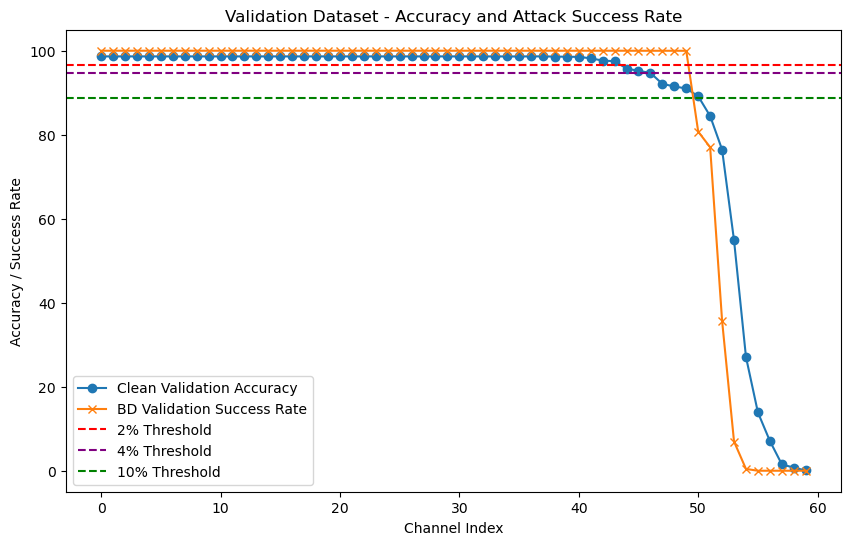

In [12]:
x_axis = list(range(len(seq)))
plt.figure(figsize=(10, 6))

plt.plot(x_axis, clean_val_acc, label='Clean Validation Accuracy', marker='o')
plt.plot(x_axis, bd_asr, label='BD Validation Success Rate', marker='x')

thresholds = [2, 4, 10]
colors = ['red', 'purple', 'green']
threshold_labels = ['2% Threshold', '4% Threshold', '10% Threshold']

for threshold, color, label in zip(thresholds, colors, threshold_labels):
    plt.axhline(max(clean_val_acc) - threshold, linestyle='--', label=label, color=color)

plt.legend()
plt.title('Validation Dataset - Accuracy and Attack Success Rate')
plt.xlabel('Channel Index')
plt.ylabel('Accuracy / Success Rate')

plt.show()


# GoodNet

In [13]:
# Defining Good Net (G) Model which uses both B and B' for prediction. It␣identifies and labels the detected Bad Samples as n+1 class.
class G(keras.Model):
    def __init__(self, B,B_dash,num_classes=1283):
        super().__init__() 
        self.B = keras.models.load_model(B)
        self.B_dash = keras.models.load_model(B_dash)
        self.bd_class = num_classes 


    def predict(self, data):
        B_pred = np.argmax(self.B.predict(data, verbose=1), axis=1)
        B_dash_pred = np.argmax(self.B_dash.predict(data, verbose=1), axis=1)

        y_preds = []
        for i in range(len(B_pred)):
            if B_pred[i] == B_dash_pred[i]:
                y_preds.append(B_pred[i])
            else:
                y_preds.append(self.bd_class)
        
        return y_preds


In [14]:
cl_test_file = 'C:\\Users\\DarkShepard\\Desktop\\lab3\\cl\\test.h5'
bd_test_file = 'C:\\Users\\DarkShepard\\Desktop\\lab3\\bd\\bd_test.h5'
test_model_X_2_file = 'model_X=2.h5'
test_model_X_4_file = 'model_X=4.h5'
test_model_X_10_file = 'model_X=10.h5'

In [15]:
cl_X_test,cl_y_test = load_data(cl_test_file)
bd_X_test,bd_y_test = load_data(bd_test_file)
print("cl test data shape: ",cl_X_test.shape)
print("bd test data shape: ",bd_X_test.shape)

cl test data shape:  (12830, 55, 47, 3)
bd test data shape:  (12830, 55, 47, 3)


In [16]:
G_X_2 = G(model_file, test_model_X_2_file)
# Predict on Clean Set
cl_test_pred_2 = G_X_2.predict(cl_X_test)
cl_test_acc_2 = np.mean(np.equal(cl_test_pred_2, cl_y_test))*100
print('Clean Classification Accuracy:', cl_test_acc_2)
# Predict on Bad Set
bd_test_pred_2 = G_X_2.predict(bd_X_test)
bd_test_sr_2 = np.mean(np.equal(bd_test_pred_2, bd_y_test))*100
print('Attack Success Rate:', bd_test_sr_2)


401/401 [==============================] - 1s 3ms/step
Clean Classification Accuracy: 95.74434918160561
401/401 [==============================] - 1s 3ms/step
Attack Success Rate: 100.0


In [17]:
G_X_4 = G(model_file, test_model_X_4_file)
# Predict on Clean Set
cl_test_pred_4 = G_X_4.predict(cl_X_test)
cl_test_acc_4 = np.mean(np.equal(cl_test_pred_4, cl_y_test))*100
print('Clean Classification Accuracy:', cl_test_acc_4)
# Predict on Bad Set
bd_test_pred_4 = G_X_4.predict(bd_X_test)
bd_test_sr_4 = np.mean(np.equal(bd_test_pred_4, bd_y_test))*100
print('Attack Success Rate:', bd_test_sr_4)


401/401 [==============================] - 1s 2ms/step
Clean Classification Accuracy: 92.1278254091972
401/401 [==============================] - 1s 2ms/step
Attack Success Rate: 99.98441153546376


In [18]:
G_X_10 = G(model_file, test_model_X_10_file)
# Predict on Clean Set
cl_test_pred_10 = G_X_10.predict(cl_X_test)
cl_test_acc_10 = np.mean(np.equal(cl_test_pred_10, cl_y_test))*100
print('Clean Classification Accuracy:', cl_test_acc_10)
# Predict on Bad Set
bd_test_pred_10 = G_X_10.predict(bd_X_test)
bd_test_sr_10 = np.mean(np.equal(bd_test_pred_10, bd_y_test))*100
print('Attack Success Rate:', bd_test_sr_10)

401/401 [==============================] - 1s 3ms/step
Clean Classification Accuracy: 84.3335931410756
401/401 [==============================] - 1s 2ms/step
Attack Success Rate: 77.20187061574435


In [19]:
test_acc = [cl_test_acc_2, cl_test_acc_4, cl_test_acc_10]
attack_rate = [bd_test_sr_2, bd_test_sr_4, bd_test_sr_10]
data = {
    "Accuracy": test_acc,
    "Attack_Rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,Accuracy,Attack_Rate
model,,
repaired_2%,95.744349,100.000000
repaired_4%,92.127825,99.984412
repaired_10%,84.333593,77.201871
